In [1]:
import tensorflow as tf
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt

In [2]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [3]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda img: tf.image.resize(img, (120,120)))
train_images = train_images.map(lambda img: img/255)

In [4]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda img: tf.image.resize(img, (120,120)))
val_images = val_images.map(lambda img: img/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda img: tf.image.resize(img, (120,120)))
test_images = test_images.map(lambda img: img/255)

In [6]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [7]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

In [8]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

#  Combine Label and Image Samples

In [10]:
train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(6000).batch(8).prefetch(4)

In [11]:
val = tf.data.Dataset.zip((val_images, val_labels)).shuffle(1000).batch(8).prefetch(4)

In [12]:
test = tf.data.Dataset.zip((test_images, test_labels)).shuffle(1000).batch(8).prefetch(4)

# Neural Network

In [13]:
vgg = tf.keras.applications.VGG16(include_top=False)

In [14]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
def build_model():
    input_layer = tf.keras.layers.Input(shape=(120,120,3))
    
    vgg = tf.keras.applications.VGG16(include_top=False)(input_layer)
    
    f1 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    clas_1 = tf.keras.layers.Dense(2048, activation='relu')(f1)
    clas_2 = tf.keras.layers.Dense(1, activation='sigmoid')(clas_1)
    
    f2 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    reg_1 = tf.keras.layers.Dense(2048, activation='relu')(f2)
    reg_2 = tf.keras.layers.Dense(4, activation='sigmoid')(reg_1)
    
    facedetector = tf.keras.models.Model(inputs=input_layer, outputs=[clas_2, reg_2])
    return facedetector

In [16]:
facedetector = build_model()

In [17]:
facedetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [18]:
X, y = train.as_numpy_iterator().next()

In [19]:
X.shape

(8, 120, 120, 3)

In [20]:
classes, coords = facedetector.predict(X)

1/1 [==============================] - 0s 465ms/step


# Losses and Optimizers

In [21]:
batch = len(train)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=(1./0.75-1)/batch)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [23]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true-w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [24]:
clasLoss = tf.keras.losses.BinaryCrossentropy()
regLoss = localization_loss

# Train Neural Network

In [25]:
class Melathy(tf.keras.models.Model):
    def __init__(self, facedetector, **kwargs):
        super().__init__(**kwargs)
        self.model = facedetector
    
    def compile(self, optimizer, clasLoss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = clasLoss
        self.lloss = localizationloss
        self.optimizer = optimizer
        self.sampling_rate = 30
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "regress_loss": batch_localloss,
        }
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self. model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localloss = self.lloss(tf.cast(y[1], tf.float32), coords)    
        total_loss = batch_localloss+0.5*batch_classloss
        
        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "regress_loss": batch_localloss,
        }
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [26]:
model = Melathy(facedetector)

In [27]:
model.compile(optimizer, clasLoss, regLoss)

In [36]:
history = model.fit(train, epochs=10, validation_data=val, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logdir')])

Epoch 1/10
494/494 [==============================] - 771s 2s/step - total_loss: 0.4635 - class_loss: 0.0762 - regress_loss: 0.4253 - val_total_loss: 0.9423 - val_class_loss: 0.8260 - val_regress_loss: 0.5293
Epoch 2/10
494/494 [==============================] - 876s 2s/step - total_loss: 0.1404 - class_loss: 0.0271 - regress_loss: 0.1268 - val_total_loss: 0.9442 - val_class_loss: 0.8138 - val_regress_loss: 0.5373
Epoch 3/10
494/494 [==============================] - 890s 2s/step - total_loss: 0.0607 - class_loss: 0.0095 - regress_loss: 0.0559 - val_total_loss: 0.0578 - val_class_loss: 2.0085e-04 - val_regress_loss: 0.0577
Epoch 4/10
494/494 [==============================] - 857s 2s/step - total_loss: 0.0235 - class_loss: 0.0016 - regress_loss: 0.0227 - val_total_loss: 0.0340 - val_class_loss: 4.1276e-06 - val_regress_loss: 0.0339
Epoch 5/10
494/494 [==============================] - 884s 2s/step - total_loss: 0.0215 - class_loss: 0.0048 - regress_loss: 0.0191 - val_total_loss: 0.0129

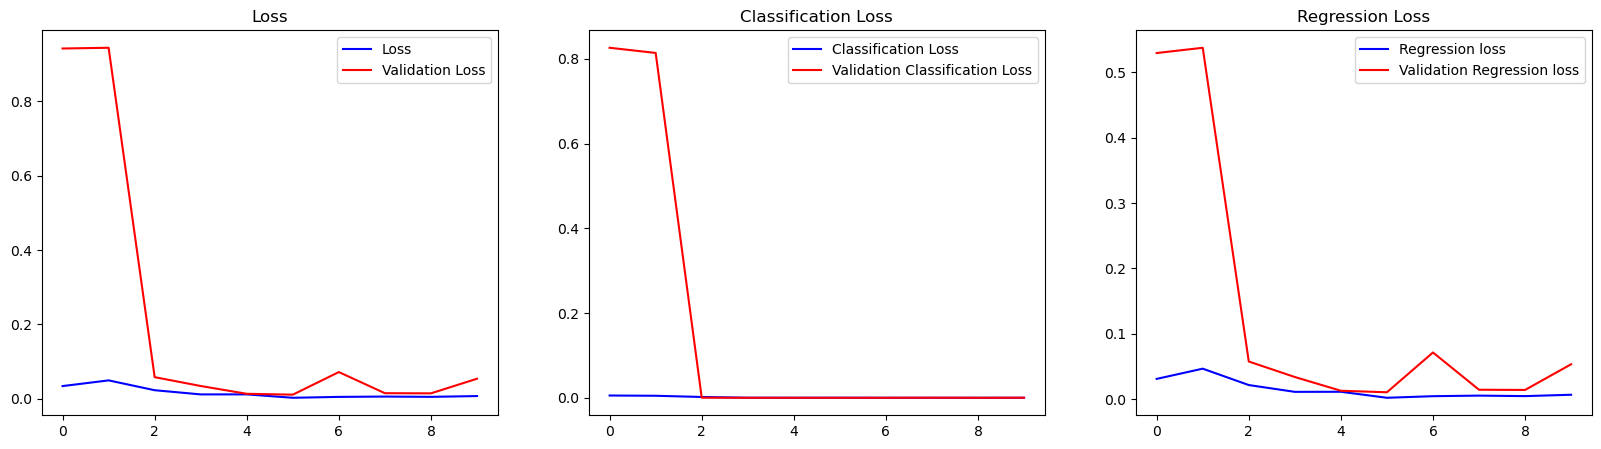

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='blue', label='Loss')
ax[0].plot(history.history['val_total_loss'], color='red', label='Validation Loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='blue', label='Classification Loss')
ax[1].plot(history.history['val_class_loss'], color='red', label='Validation Classification Loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['regress_loss'], color='blue', label='Regression loss')
ax[2].plot(history.history['val_regress_loss'], color='red', label='Validation Regression loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [38]:
test_data = test.as_numpy_iterator()

In [39]:
test_sample = test_data.next()

In [40]:
yhat = facedetector.predict(test_sample[0])

1/1 [==============================] - 0s 363ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


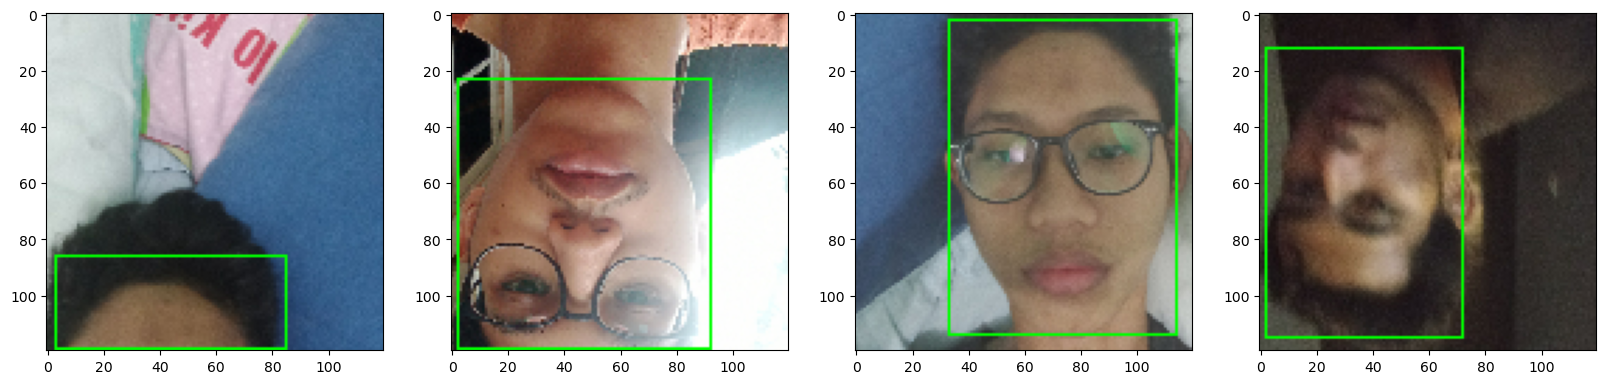

In [41]:
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    sample_image = test_sample[0][i]
    sample_coords = yhat[1][i]
    
    if yhat[0][i] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                       tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (0,255,0), 1)
        
    ax[i].imshow(sample_image)

In [42]:
facedetector.save('facedetection.h5')